In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [75]:
"""
Author			: Muhammad Arifin
Institution		: Department of Nuclear Engineering and Engineering Physics, Universitas Gadjah Mada
Initial Release	: 29th April, 2020
License			: MIT License

Description		: This program is a direct implementation of mathematical equations
				  used to calculate path loss exponent information from path loss 
				  measurement data. The implementation is based on theoritical 
				  explanation on Andreas Goldsmith's Wireless Communications book
				  chapter 2 on Path Loss and Shadowing. 

Licensing		: This program is licensed under MIT License. 
				  MIT License

Copyright (c) [2020] [Muhammad Arifin]

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

import numpy as np 
import sympy as sym
import matplotlib.pyplot as plt 


class Pathloss:
	def __init__(self, distance, measured, frequency):
		"""
		Class for creating a path loss object.

		Distance is an array of distances from Tx to Rx.
		Measured is the measured rssi values 
		corresponding to the given distance.
		"""

		# distance and rssi values
		self.dist = distance
		self.meas = measured

		# Finding total Number of data
		self.num_data = len(self.dist)

		# Finding measured rssi at d0
		self.freq = frequency
		self.light_speed = 3e8
		self.wavelength  = self.light_speed / self.freq
		self.d0 = 1.0
		#self.k = -20*np.log10(4 * np.pi * self.d0 / self.wavelength)
		self.k = self.meas[1]

		# Finding log distance
		self.log_dist = np.log10(self.dist)

		# symbolic path loss exponent
		self.n = sym.Symbol('n')


	def finding_ple(self):
		"""
		Pathloss class method to calculate path loss exponent
		given distances and measured rssi data.

		Calculation is based on Andreas Goldsmith Wireless
		Communications book p.40 of examples 2.3

		"""
		# Calculating F(n)
		self.fn = (self.meas - self.k + 10*self.n*self.log_dist)**2
		self.fn_result = 0

		for res in self.fn:
			self.fn_result += res # Summing all the component

		# Calculating PLE (n) by differentiating F(n)
		# then assign dF(n) / dn = 0 for minimum error value
		self.diffn  = sym.diff(self.fn) 
		self.diff_result = 0

		for num in self.diffn:
			self.diff_result += num

		self.str_result = str(self.diff_result).replace('*n','').split('-') #list values
		self.ple_result = round(float(self.str_result[1])/float(self.str_result[0]), 2)	

		return self.ple_result

	def finding_stdev(self):
		"""
		Pathloss class method to calculate standar deviation
		from given distances and rssi data. 

		Calculation is based on Andreas Goldsmith Wireless
		Communications book p.46 of examples 2.4
		"""
		# finding variance
		self.fn_total = (self.meas - self.k + 10*self.ple_result*self.log_dist)**2
		self.variance = 0

		for var in self.fn_total:
			self.variance += var # summing all the components

		self.std_dev = round(np.sqrt(self.variance / self.num_data) ,2)

		return self.std_dev

	def path_loss_model_simplified(self):
		"""
		Pathloss class method to calculate the simplified path loss model.
		"""

		self.path_loss_simplified = self.k - 10*self.ple_result*np.log10(self.dist)
		#self.path_loss_simplified = self.k - 10*3.71*np.log10(self.dist)
		return self.path_loss_simplified


	def path_loss_model_shadowing(self):
		"""
		Pathloss class method to calculate the path loss model with shadowing.
		Shadowing is modeled using gaussian random noise
		"""

		#Gaussian random noise with mean = 0 and sigma = std_dev
		self.mean = 0
		self.gaussian_noise = np.random.normal(self.mean, self.std_dev, self.num_data)
		#self.gaussian_noise = np.random.normal(self.mean, 3.65, self.num_data)

		# Path loss model with shadowing modeled as gaussian random noise
		self.path_loss_shadowing = self.path_loss_simplified + self.gaussian_noise

		return self.path_loss_shadowing


def plotGraph(fx, x, legend):
	#plt.figure("Path Loss Graph")
	plt.plot(x, fx, "o-", label = str(legend))
	plt.title("Path Loss")
	plt.xlabel("d (m)")
	plt.ylabel("RSSI (dBm)")
	plt.ylim([-75, -35])
	plt.xlim([0, max(x)])
	plt.xticks(np.arange(0.0,5.0,0.5))
	plt.yticks(np.arange(-75,-30,5))
	plt.legend()
	plt.grid(color='lightgray', zorder = 10)
	plt.show()

def main():
	# Distance and measured rssi data

	dist = np.array([0.5, 0.7, 0.9, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0, 3.2, 3.5, 3.7, 4.0, 4.2, 4.5, 4.7, 5.0, 5.5])
	meas = np.array([-39, -42, -51, -49, -50, -53, -58, -60, -68, -60, -60, -56, -59, -62, -60, -62, -64, -68])
	f 	 = 2.4e9

	pathloss = Pathloss(dist, meas, f)
	plexp = pathloss.finding_ple()
	stdev = pathloss.finding_stdev()
	plmodel_simplified = pathloss.path_loss_model_simplified()
	plmodel_shadowing  = pathloss.path_loss_model_shadowing()

	print("Path Loss Exponent: ", plexp)
	print("Standard Deviation: ", stdev)
	print("Simplified Path Loss Model: ", plmodel_simplified)
	print("Path Loss Model with Shadowing: ", plmodel_shadowing)

	plotGraph(meas, dist, "Measured")
	plotGraph(plmodel_simplified, dist, "Simplified")
	plotGraph(plmodel_shadowing, dist, "Shadowing")


main()

ValueError: 
Can't calculate derivative wrt 9.06190582894565*Abs((n -
0.996578428466209)**2).

In [31]:
wifi_filename = "wifi_data.csv"
wifi_data = pd.read_csv(wifi_filename)
wifi_data.columns.values

array(['version', 'buiildingId', 'x', 'y', 'floor', 'SSID', 'level',
       'timestamp', 'frequency', 'BSSID', 'capabilities', 'uploadedAt'],
      dtype=object)

In [32]:
f_1 = wifi_data[wifi_data['floor'] == -1]
f0 = wifi_data[wifi_data['floor'] == 0]

In [33]:
global_x_min = wifi_data['x'].min()
global_x_max = wifi_data['x'].max()
global_y_min = wifi_data['y'].min()
global_y_max = wifi_data['y'].max()

In [34]:
def remove_ap_by_occurances(data,threshold):
    ssid_counts = data['SSID'].value_counts()
    common_ssids = ssid_counts[ssid_counts >= threshold].index
    filtered_wifi_data = data[data['SSID'].isin(common_ssids)]
    return filtered_wifi_data

def remove_macs_by_occurances(data,threshold):
    ssid_counts = data['BSSID'].value_counts()
    common_ssids = ssid_counts[ssid_counts >= threshold].index
    filtered_wifi_data = data[data['BSSID'].isin(common_ssids)]
    return filtered_wifi_data

def remove_all_weak_rss(data,threshold):
    filtered_data = data[data['level'] >= threshold]
    return filtered_data

def remove_hidden_ssid(data):
    title = "(hidden SSID)"
    filtered_data = data[data['SSID'] != title]
    return filtered_data


def get_ssid_map_area(data,ssid):
    filtered_data = data[data['SSID'] == ssid]
    x_min = filtered_data['x'].min()
    x_max = filtered_data['x'].max()
    y_min = filtered_data['y'].min()
    y_max = filtered_data['y'].max()
    return (
        x_min,
        x_max,
        y_min,
        y_max,
    )

def plot(data,ssid):
    pass
    

In [35]:
wifi_data['level'].min(),wifi_data['level'].max()

(-101, -7)

In [36]:
min_ap_occurances_threhsold = 200
rss_threshold = -75

data = remove_ap_by_occurances(wifi_data,min_ap_occurances_threhsold)
data = remove_hidden_ssid(data)
data = remove_all_weak_rss(data,rss_threshold)
data['SSID'].value_counts()

SSID
Afeka-Staff        898
Afeka-Wifi-Open    820
Afeka-Students     814
Name: count, dtype: int64

In [37]:
data['level'].min(),data['level'].max()

(-75, -8)

In [40]:
len(data)

2532

In [52]:
agg_data = data.groupby(['x','y','floor']).agg(lambda x: list(x))
agg_data

version  \
x    y   floor                                                      
0    35   0     [Line_1_top_left_down, Line_1_top_left_down, L...   
35   0   -1     [Line_1_top_left_down, Line_1_top_left_down, L...   
     5    0     [Line_1_top_left_down, Line_1_top_left_down, L...   
     100  0     [Line_1_top_left_down, Line_1_top_left_down, L...   
     316 -1     [llastbounda_3ry, llastbounda_3ry, llastbounda...   
...                                                           ...   
1047 336 -1     [Line_5_stairs_down_15, Line_5_stairs_down_15,...   
     461 -1     [Line_5_stairs_down_15, Line_5_stairs_down_15,...   
     551 -1     [Line_5_stairs_down_14, Line_5_stairs_down_14,...   
     656 -1     [Line_5_stairs_down_14, Line_5_stairs_down_14,...   
1226 30   0                                    [Line_1_top_right]   

                                                      buiildingId  \
x    y   floor                                                      
0    35   0     [e384f534f12c984588d8868e, e384f534f12c984588d...   
35   0   -1     [e384f534f12c984588d8868e, e384f534f12c984588d...   
     5    0     [e384f534f12c984588d8868e, e384f534f12c984588d...   
     100  0     [e384f534f12c984588d8868e, e384f534f12c984588d...   
     316 -1     [e384f534f12c984588d8868e, e384f534f12c984588d...   
...                                                           ...   
1047 336 -1     [e384f534f12c984588d8868e, e384f534f12c984588d...   
     461 -1     [e384f534f12c984588d8868e, e384f534f12c984588d...   
     551 -1     [e384f534f12c984588d8868e, e384f534f12c984588d...   
     656 -1     [e384f534f12c984588d8868e, e384f534f12c984588d...   
1226 30   0                            [e384f534f12c984588d8868e]   

                                                             SSID  \
x    y   floor                                                      
0    35   0     [Afeka-Staff, Afeka-Students, Afeka-Wifi-Open,...   
35   0   -1     [Afeka-Wifi-Open, Afeka-Staff, Afeka-Students,...   
     5    0     [Afeka-Staff, Afeka-Students, Afeka-Wifi-Open,...   
     100  0     [Afeka-Staff, Afeka-Students, Afeka-Wifi-Open,...   
     316 -1     [Afeka-Staff, Afeka-Students, Afeka-Staff, Afe...   
...                                                           ...   
1047 336 -1     [Afeka-Students, Afeka-Staff, Afeka-Wifi-Open,...   
     461 -1     [Afeka-Students, Afeka-Staff, Afeka-Wifi-Open,...   
     551 -1     [Afeka-Students, Afeka-Staff, Afeka-Wifi-Open,...   
     656 -1     [Afeka-Students, Afeka-Staff, Afeka-Wifi-Open,...   
1226 30   0                                         [Afeka-Staff]   

                                                            level  \
x    y   floor                                                      
0    35   0              [-73, -74, -74, -58, -59, -59, -50, -50]   
35   0   -1                             [-54, -54, -54, -49, -49]   
     5    0              [-73, -72, -73, -66, -66, -66, -51, -50]   
     100  0     [-71, -71, -72, -62, -62, -61, -43, -43, -70, ...   
     316 -1     [-73, -73, -73, -72, -74, -73, -70, -70, -70, ...   
...                                                           ...   
1047 336 -1     [-64, -64, -64, -72, -72, -72, -71, -70, -70, ...   
     461 -1     [-74, -73, -74, -71, -70, -70, -69, -69, -69, ...   
     551 -1     [-61, -61, -60, -67, -66, -68, -44, -46, -44, ...   
     656 -1     [-67, -68, -67, -63, -63, -63, -70, -69, -62, ...   
1226 30   0                                                 [-74]   

                                                        timestamp  \
x    y   floor                                                      
0    35   0     [302702195349, 302702195353, 302702195344, 302...   
35   0   -1     [302640860909, 302640860913, 302640860916, 302...   
     5    0     [302739373408, 302739373413, 302739373404, 302...   
     100  0     [302764993000, 302764993005, 302764992995, 302...   
     316 -1     [322931208886, 322931208890, 3229312

In [57]:
agg_data['level']

x     y    floor
0     35    0                [-73, -74, -74, -58, -59, -59, -50, -50]
35    0    -1                               [-54, -54, -54, -49, -49]
      5     0                [-73, -72, -73, -66, -66, -66, -51, -50]
      100   0       [-71, -71, -72, -62, -62, -61, -43, -43, -70, ...
      316  -1       [-73, -73, -73, -72, -74, -73, -70, -70, -70, ...
                                          ...                        
1047  336  -1       [-64, -64, -64, -72, -72, -72, -71, -70, -70, ...
      461  -1       [-74, -73, -74, -71, -70, -70, -69, -69, -69, ...
      551  -1       [-61, -61, -60, -67, -66, -68, -44, -46, -44, ...
      656  -1       [-67, -68, -67, -63, -63, -63, -70, -69, -62, ...
1226  30    0                                                   [-74]
Name: level, Length: 162, dtype: object

In [51]:
agg_data.iloc[3]['floor']

KeyError: 'floor'

In [39]:
db_data = data[0:]
test_data = data[0:]

In [9]:
bins = 50
vmax = 8
vmin = 1
figsize = (4,3)

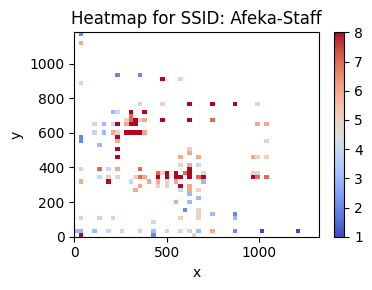

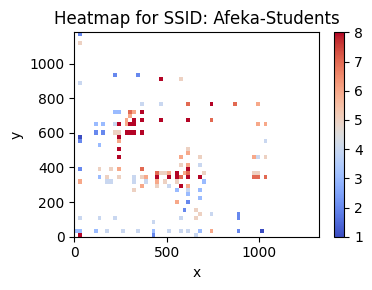

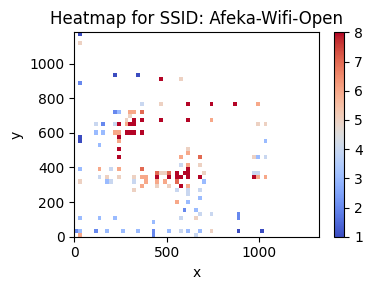

In [132]:
grouped_data = data.groupby('SSID')
for ssid, group in grouped_data:
    plt.figure(figsize=figsize)
    sns.histplot(data=group, x='x', y='y', bins=bins, cmap='coolwarm', cbar=True,
                 vmin=vmin, vmax=vmax)
    plt.title(f'Heatmap for SSID: {ssid}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(global_x_min, global_x_max)
    plt.ylim(global_y_min, global_y_max)
    plt.tight_layout()
    plt.show() 

In [94]:
len(data.groupby(["BSSID"]))

289

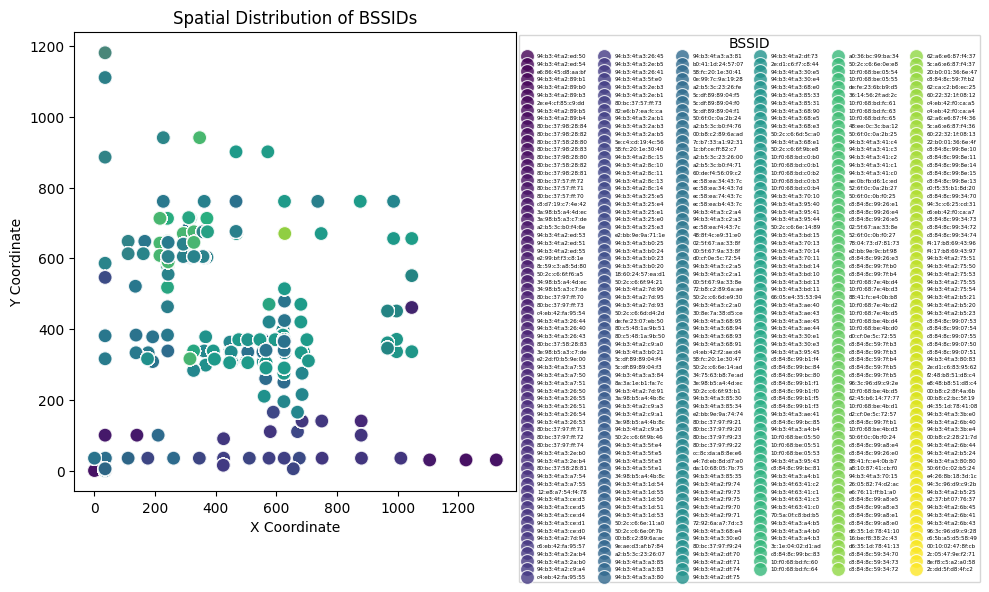

In [95]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=wifi_data, x='x', y='y', hue='BSSID', palette='viridis', legend='full', s=100, alpha=0.8)
plt.title('Spatial Distribution of BSSIDs')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='BSSID', loc='upper left', bbox_to_anchor=(1, 1),fontsize=4,ncols=6)
plt.tight_layout()
plt.show()

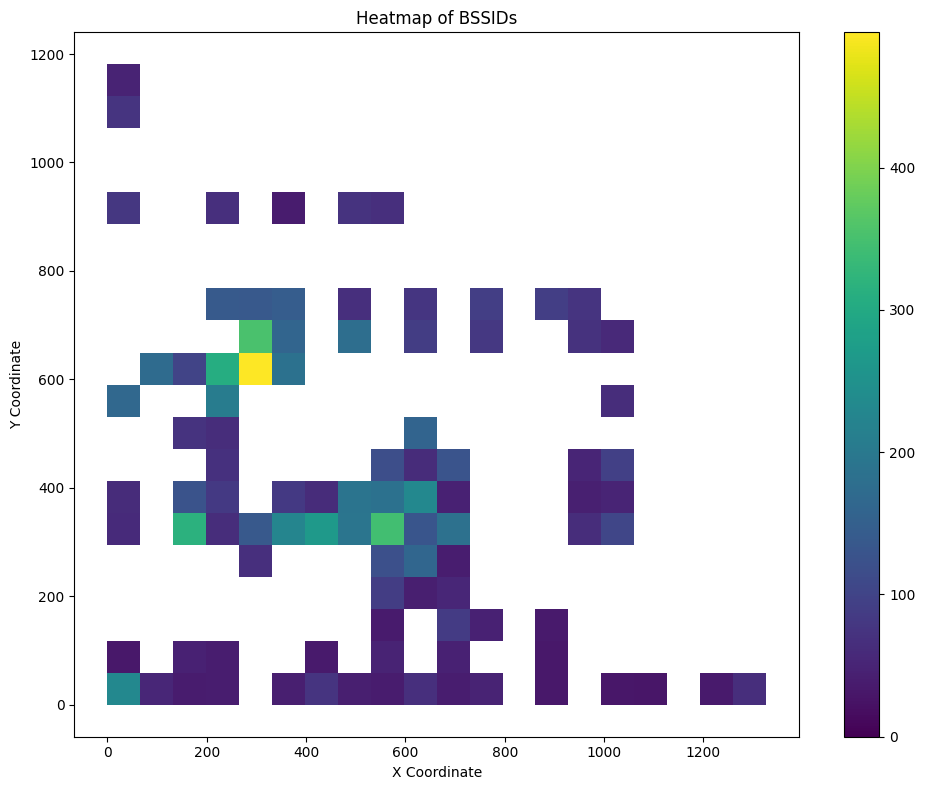

In [96]:
plt.figure(figsize=(10, 8))
sns.histplot(data=wifi_data, x='x', y='y', bins=20, cmap='viridis', cbar=True)
plt.title('Heatmap of BSSIDs')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.tight_layout()
plt.show()

In [97]:
ssid_bssid_counts = data.groupby(['SSID', 'BSSID']).size().reset_index(name='Count')
ssid_bssid_counts

,SSID,BSSID,Count
0,(hidden SSID),02:5f:67:aa:33:8e,15
1,(hidden SSID),02:5f:67:aa:33:8f,11
2,(hidden SSID),10:f0:68:7e:4b:d3,4
3,(hidden SSID),10:f0:68:bd:c0:b1,14
4,(hidden SSID),10:f0:68:bd:c0:b2,12
...,...,...,...
284,Afeka-Wifi-Open,c8:84:8c:99:8e:10,9
285,Afeka-Wifi-Open,c8:84:8c:99:a8:e0,25
286,Afeka-Wifi-Open,c8:84:8c:99:b1:f0,62
287,Afeka-Wifi-Open,c8:84:8c:99:bc:80,82


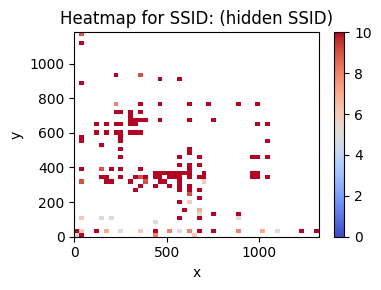

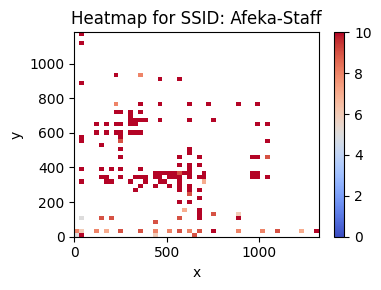

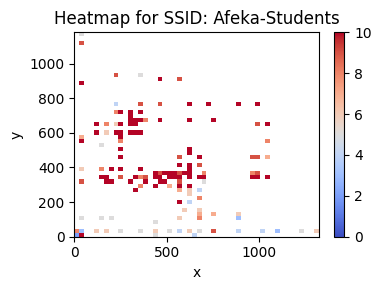

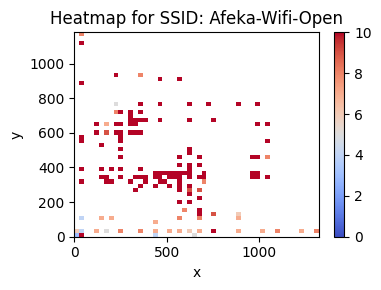

In [98]:
grouped_data = data.groupby('SSID')
for ssid, group in grouped_data:
    plt.figure(figsize=figsize)
    sns.histplot(data=group, x='x', y='y', bins=bins, cmap='coolwarm', cbar=True,
                 vmin=vmin, vmax=vmax)
    plt.title(f'Heatmap for SSID: {ssid}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(global_x_min, global_x_max)
    plt.ylim(global_y_min, global_y_max)
    plt.tight_layout()
    plt.show() 

In [29]:
data

[{'_id': '6670182ac2042cc55abfdfde',
  'buildingId': 'e384f534f12c984588d8868e',
  'version': 'Line_1_top_right',
  'points': [{'id': '1718622066193-7308',
    'title': 'e384f534f12c984588d8868e@None@POINT@F0@1326@30@up@20240617140106@0',
    'timestamp': '20240617140106',
    'rawDate': '2024-06-17T11:01:06.193Z',
    'test': False,
    'uncertain': False,
    'floor': 0,
    'x': 1326,
    'y': 30,
    'deviceOrientation': {'roll': 0, 'pitch': 0, 'yaw': 0},
    'direction': 'up',
    'isHighTurbuance': False,
    'magnetometerData': {'eventMode': 'continuous',
     'sensorName': 'MXG4300S Magnetometer',
     'firstEventAfterDiscontinuity': False,
     'timestamp': 1718622065414,
     'rawTimestamp': '301137640476051',
     'event': 'data',
     'data': {'z': 48.358001708984375,
      'y': 3.6760001182556152,
      'x': 43.44600296020508},
     'rawData': [43.44600296020508, 3.6760001182556152, 48.358001708984375]},
    'magnetometerUncalibData': {'eventMode': 'continuous',
     'sens

In [61]:
len(wpoints)

176

In [62]:
wpoints[0]

{'x': 1326,
 'y': 30,
 'floor': 0,
 'wifiData': [{'timestamp': 301137657238,
   'level': -98,
   'frequency': 2437,
   'capabilities': '[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS][WPS]',
   'BSSID': '3a:98:b5:a4:4d:ec',
   'SSID': 'ORBI94 scharfstein'},
  {'timestamp': 301137657210,
   'level': -97,
   'frequency': 2437,
   'capabilities': '[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS][WPS]',
   'BSSID': '3a:98:b5:a3:c7:de',
   'SSID': 'ORBI94 scharfstein'},
  {'timestamp': 301137657202,
   'level': -98,
   'frequency': 2412,
   'capabilities': '[WPA2-PSK-CCMP][RSN-PSK-CCMP][ESS][WPS]',
   'BSSID': 'a2:b5:3c:b0:f4:6e',
   'SSID': 'Naama'},
  {'timestamp': 301137657255,
   'level': -80,
   'frequency': 5300,
   'capabilities': '[ESS]',
   'BSSID': '94:b3:4f:a2:ed:50',
   'SSID': 'Afeka-Wifi-Open'},
  {'timestamp': 301137657260,
   'level': -80,
   'frequency': 5300,
   'capabilities': '[ESS]',
   'BSSID': '94:b3:4f:a2:ed:54',
   'SSID': 'Afeka-Staff'},
  {'timestamp': 301133679323,
   'level': -81,
   'fre

In [68]:
db_data = wpoints[0:int(len(wpoints) * 90 / 100)]
test_data = wpoints[int(len(wpoints) * 90 / 100):len(wpoints)]
len(db_data),len(test_data)

(158, 18)

In [14]:



rows = []
for f in filtered_data:    
    v = f['version']
    bid = f['buildingId']
    uplo = f['createdAt']
    for point in f['points']:
        x, y, floor = point['x'], point['y'], point['floor']
        if point['wifiData']:
            for wifi in point['wifiData']:
                ssid = wifi['SSID']
                level = wifi['level']
                timestamp = wifi['timestamp']
                frequency = wifi['frequency']
                capabilities = wifi['capabilities']
                bssid = wifi['BSSID']
                
                rows.append([v,bid,x, y, floor, ssid,level,timestamp,frequency,bssid,capabilities,uplo])
len(rows)                

NameError: name 'filtered_data' is not defined

In [76]:
import math
import numpy as np

def filter_rss_by_threshold(rss_array, threshold):
    return [rss for rss in rss_array if rss >= threshold]

def linear_interpolation(rss1, rss2, n, i):
    return ((n - i) / n) * rss1 + (i / n) * rss2

def adaptive_interpolation(rss_array, f1, f2):
    n = math.floor(f1 / f2)
    interpolated_rss = []
    for i in range(len(rss_array) - 1):
        for j in range(n):
            interpolated_rss.append(linear_interpolation(rss_array[i], rss_array[i + 1], n, j))
    interpolated_rss.append(rss_array[-1])  # Include the last original RSS
    return interpolated_rss

def normalize(array):
    mean = np.mean(array)
    std_dev = np.std(array)
    return [(val - mean) / std_dev for val in array]

def calculate_weights(rss_array):
    max_rss = max(rss_array)
    return [math.exp(rss / max_rss) for rss in rss_array]

def compute_weighted_distance(rss, rssdb, weights):
    p = len(rss)
    distance = 0
    for k in range(p):
        distance += weights[k] * (rss[k] - rssdb[k]) ** 2
    return distance

def mdtw_with_wls(rss, rssdb, weights):
    n = len(rss)
    m = len(rssdb)
    d = np.zeros((n, m))

    for i in range(n):
        for j in range(m):
            d[i][j] = compute_weighted_distance(rss[i], rssdb[j], weights)

    D = np.zeros((n, m))
    D[0][0] = d[0][0]

    for i in range(1, n):
        D[i][0] = d[i][0] + D[i - 1][0]

    for j in range(1, m):
        D[0][j] = d[0][j] + D[0][j - 1]

    for i in range(1, n):
        for j in range(1, m):
            D[i][j] = d[i][j] + min(D[i - 1][j], D[i][j - 1], D[i - 1][j - 1])

    return D[n - 1][m - 1]

def weighted_least_squares(positions, distances, sigma):
    weights = [1 / math.exp(di ** 2 / (2 * sigma ** 2)) for di in distances]
    total_weight = sum(weights)

    normalized_weights = [w / total_weight for w in weights]

    estimated_x = sum(normalized_weights[i] * positions[i][0] for i in range(len(positions)))
    estimated_y = sum(normalized_weights[i] * positions[i][1] for i in range(len(positions)))

    return {'x': estimated_x, 'y': estimated_y}

def match_fingerprints(user_input, database_fingerprints):
    matched_rss = []
    matched_dbrss = []

    for user_network in user_input:
        db_network = next((db_network for db_network in database_fingerprints if db_network['ssid'] == user_network['ssid']), None)
        if db_network:
            matched_rss.append(user_network['rss'])
            matched_dbrss.append(db_network['rss'])

    return {'matched_rss': matched_rss, 'matched_dbrss': matched_dbrss}

def estimate_position(user_input, database_fingerprints, threshold, f1, f2, sigma, r):
    matched = match_fingerprints(user_input, database_fingerprints)

    filtered_rss = [filter_rss_by_threshold(rss_array, threshold) for rss_array in matched['matched_rss']]

    interpolated_rss = [adaptive_interpolation(rss_array, f1, f2) for rss_array in filtered_rss]

    normalized_rss = [normalize(rss) for rss in interpolated_rss]
    normalized_dbrss = [normalize(rss) for rss in matched['matched_dbrss']]

    weights = calculate_weights([val for sublist in interpolated_rss for val in sublist])

    distances = [mdtw_with_wls(rss, normalized_dbrss[i], weights) for i, rss in enumerate(normalized_rss)]

    sorted_distances = sorted(
        [{'distance': d, 'position': (database_fingerprints[i]['x'], database_fingerprints[i]['y'])} for i, d in enumerate(distances)],
        key=lambda x: x['distance']
    )

    top_r = sorted_distances[:r]

    positions = [item['position'] for item in top_r]
    distance_values = [item['distance'] for item in top_r]

    estimated_position = weighted_least_squares(positions, distance_values, sigma)

    return estimated_position

# Example database fingerprints with positions
database_fingerprints = [
    {
        'ssid': 'network1',
        'rss': [-78, -82, -85, -88, -74],
        'x': 5,
        'y': 10
    },
    {
        'ssid': 'network2',
        'rss': [-61, -63, -60, -55, -52],
        'x': 15,
        'y': 20
    }
]

# Example user input
user_input = [
    {
        'ssid': 'network1',
        'rss': [-80, -75, -90, -60, -50]
    },
    {
        'ssid': 'network2',
        'rss': [-62, -65, -67, -70, -69]
    }
]

# Parameters for position estimation
threshold = -70
f1 = 0.5  # Target sampling frequency
f2 = 0.125  # Original sampling frequency
sigma = 1  # Configuration parameter for exponential function
r = 2  # Number of top positions to consider

estimated_position = estimate_position(user_input, database_fingerprints, threshold, f1, f2, sigma, r)

print("Estimated Position:", estimated_position)


TypeError: object of type 'numpy.float64' has no len()

In [77]:
import random

# Generate random database fingerprints
def generate_random_fingerprints(num_fingerprints, num_rss_values):
    fingerprints = []
    for _ in range(num_fingerprints):
        ssid = f"network{_ + 1}"
        rss = [random.randint(-90, -30) for _ in range(num_rss_values)]
        x = random.uniform(0, 50)
        y = random.uniform(0, 50)
        fingerprints.append({'ssid': ssid, 'rss': rss, 'x': x, 'y': y})
    return fingerprints

# Generate user inputs by slightly varying the RSS values from the database
def generate_user_inputs(database_fingerprints, num_inputs, variation):
    user_inputs = []
    for _ in range(num_inputs):
        input_entry = []
        for db_entry in random.sample(database_fingerprints, len(database_fingerprints)):
            ssid = db_entry['ssid']
            rss = [rss_val + random.randint(-variation, variation) for rss_val in db_entry['rss']]
            input_entry.append({'ssid': ssid, 'rss': rss})
        user_inputs.append(input_entry)
    return user_inputs

# Calculate accuracy based on estimated vs actual positions
def calculate_accuracy(estimated_positions, actual_positions):
    total_error = 0
    errors = []
    for est_pos, act_pos in zip(estimated_positions, actual_positions):
        error = math.sqrt((est_pos['x'] - act_pos['x']) ** 2 + (est_pos['y'] - act_pos['y']) ** 2)
        errors.append(error)
        total_error += error
    avg_error = total_error / len(estimated_positions)
    return errors, avg_error

# Generate the data
num_fingerprints = 50
num_rss_values = 5
num_inputs = 10
variation = 5

database_fingerprints = generate_random_fingerprints(num_fingerprints, num_rss_values)
user_inputs = generate_user_inputs(database_fingerprints, num_inputs, variation)

# Estimate positions for user inputs
estimated_positions = []
actual_positions = [{'x': entry['x'], 'y': entry['y']} for entry in random.sample(database_fingerprints, num_inputs)]

threshold = -70
f1 = 0.5
f2 = 0.125
sigma = 1
r = 5

for user_input in user_inputs:
    estimated_position = estimate_position(user_input, database_fingerprints, threshold, f1, f2, sigma, r)
    estimated_positions.append(estimated_position)

# Calculate and print accuracy
errors, avg_error = calculate_accuracy(estimated_positions, actual_positions)

print("Individual Errors:", errors)
print("Average Error:", avg_error)

# Example database fingerprints with positions (for reproducibility)
print("Database Fingerprints:", database_fingerprints[:5])  # Print first 5 for brevity

# Example user inputs (for reproducibility)
print("User Inputs:", user_inputs[:3])  # Print first 3 for brevity

# Estimated positions
print("Estimated Positions:", estimated_positions)


/tmp/ipykernel_323959/3604165921.py:22: RuntimeWarning: invalid value encountered in double_scalars
  return [(val - mean) / std_dev for val in array]


TypeError: object of type 'numpy.float64' has no len()

In [80]:
p = wpoints[0]
_p = p['x'], p['y'], p['floor']

In [78]:
import math
import numpy as np

def filter_rss_by_threshold(rss_array, threshold):
    return [rss for rss in rss_array if rss >= threshold]

def linear_interpolation(rss1, rss2, n, i):
    return ((n - i) / n) * rss1 + (i / n) * rss2

def adaptive_interpolation(rss_array, f1, f2):
    n = math.floor(f1 / f2)
    interpolated_rss = []
    for i in range(len(rss_array) - 1):
        for j in range(n):
            interpolated_rss.append(linear_interpolation(rss_array[i], rss_array[i + 1], n, j))
    interpolated_rss.append(rss_array[-1])  # Include the last original RSS
    return interpolated_rss

def normalize(array):
    mean = np.mean(array)
    std_dev = np.std(array)
    return [(val - mean) / std_dev for val in array]

def calculate_weights(rss_array):
    max_rss = max(rss_array)
    return [math.exp(rss / max_rss) for rss in rss_array]

def compute_weighted_distance(rss, rssdb, weights):
    p = len(rss)
    distance = 0
    for k in range(p):
        distance += weights[k] * (rss[k] - rssdb[k]) ** 2
    return distance

def mdtw_with_wls(rss, rssdb, weights):
    n = len(rss)
    m = len(rssdb)
    d = np.zeros((n, m))

    for i in range(n):
        for j in range(m):
            d[i][j] = compute_weighted_distance(rss[i], rssdb[j], weights)

    D = np.zeros((n, m))
    D[0][0] = d[0][0]

    for i in range(1, n):
        D[i][0] = d[i][0] + D[i - 1][0]

    for j in range(1, m):
        D[0][j] = d[0][j] + D[0][j - 1]

    for i in range(1, n):
        for j in range(1, m):
            D[i][j] = d[i][j] + min(D[i - 1][j], D[i][j - 1], D[i - 1][j - 1])

    return D[n - 1][m - 1]

def weighted_least_squares(positions, distances, sigma):
    weights = [1 / math.exp(di ** 2 / (2 * sigma ** 2)) for di in distances]
    total_weight = sum(weights)

    normalized_weights = [w / total_weight for w in weights]

    estimated_x = sum(normalized_weights[i] * positions[i][0] for i in range(len(positions)))
    estimated_y = sum(normalized_weights[i] * positions[i][1] for i in range(len(positions)))

    return {'x': estimated_x, 'y': estimated_y}

def match_fingerprints(user_input, database_fingerprints):
    matched_rss = []
    matched_dbrss = []

    for user_network in user_input:
        db_network = next((db_network for db_network in database_fingerprints if db_network['ssid'] == user_network['ssid']), None)
        if db_network:
            matched_rss.append(user_network['rss'])
            matched_dbrss.append(db_network['rss'])

    return {'matched_rss': matched_rss, 'matched_dbrss': matched_dbrss}

def estimate_position(user_input, database_fingerprints, threshold, f1, f2, sigma, r):
    matched = match_fingerprints(user_input, database_fingerprints)

    filtered_rss = [filter_rss_by_threshold(rss_array, threshold) for rss_array in matched['matched_rss']]

    interpolated_rss = [adaptive_interpolation(rss_array, f1, f2) for rss_array in filtered_rss]

    normalized_rss = [normalize(rss) for rss in interpolated_rss]
    normalized_dbrss = [normalize(rss) for rss in matched['matched_dbrss']]

    weights = calculate_weights([val for sublist in interpolated_rss for val in sublist])

    distances = [mdtw_with_wls(rss, normalized_dbrss[i], weights) for i, rss in enumerate(normalized_rss)]

    sorted_distances = sorted(
        [{'distance': d, 'position': (database_fingerprints[i]['x'], database_fingerprints[i]['y'])} for i, d in enumerate(distances)],
        key=lambda x: x['distance']
    )

    top_r = sorted_distances[:r]

    positions = [item['position'] for item in top_r]
    distance_values = [item['distance'] for item in top_r]

    estimated_position = weighted_least_squares(positions, distance_values, sigma)

    return estimated_position

# Example database fingerprints with positions
database_fingerprints = [
    {
        'ssid': 'network1',
        'rss': [-78, -82, -85, -88, -74],
        'x': 5,
        'y': 10
    },
    {
        'ssid': 'network2',
        'rss': [-61, -63, -60, -55, -52],
        'x': 15,
        'y': 20
    }
]

# Example user input
user_input = [
    {
        'ssid': 'network1',
        'rss': [-80, -75, -90, -60, -50]
    },
    {
        'ssid': 'network2',
        'rss': [-62, -65, -67, -70, -69]
    }
]

# Parameters for position estimation
threshold = -70
f1 = 0.5  # Target sampling frequency
f2 = 0.125  # Original sampling frequency
sigma = 1  # Configuration parameter for exponential function
r = 2  # Number of top positions to consider

estimated_position = estimate_position(user_input, database_fingerprints, threshold, f1, f2, sigma, r)

print("Estimated Position:", estimated_position)


TypeError: object of type 'numpy.float64' has no len()